In [2]:
from ultralytics import YOLO
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils.court_mapper import CourtMapper
from PIL import Image
from IPython.display import display

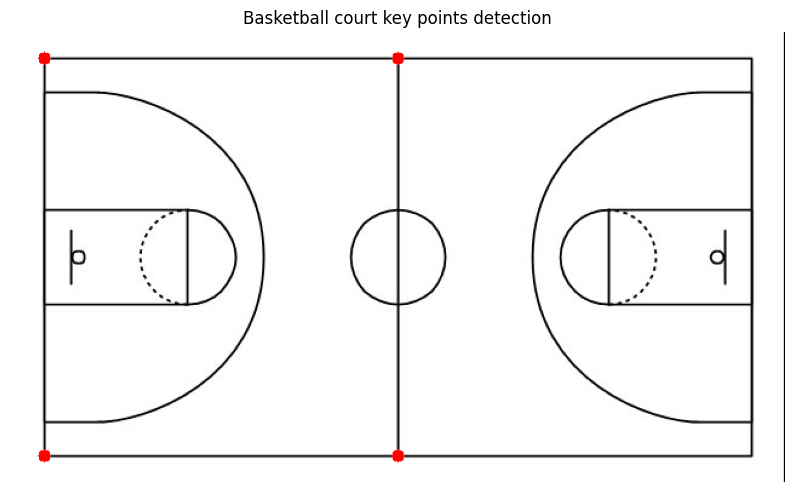

In [2]:
mapper = CourtMapper()

court_image = cv2.imread("court_diagram.jpeg")
court_image = cv2.cvtColor(court_image, cv2.COLOR_BGR2RGB)

dst_leftpts = mapper.court_leftpts


for point in dst_leftpts:
    cv2.circle(court_image, (int(point[0]), int(point[1])), 5, (255, 0, 0), -1) 

plt.figure(figsize=(10, 8))
plt.imshow(court_image)
plt.axis('off')
plt.title('Basketball court key points detection')
plt.show()

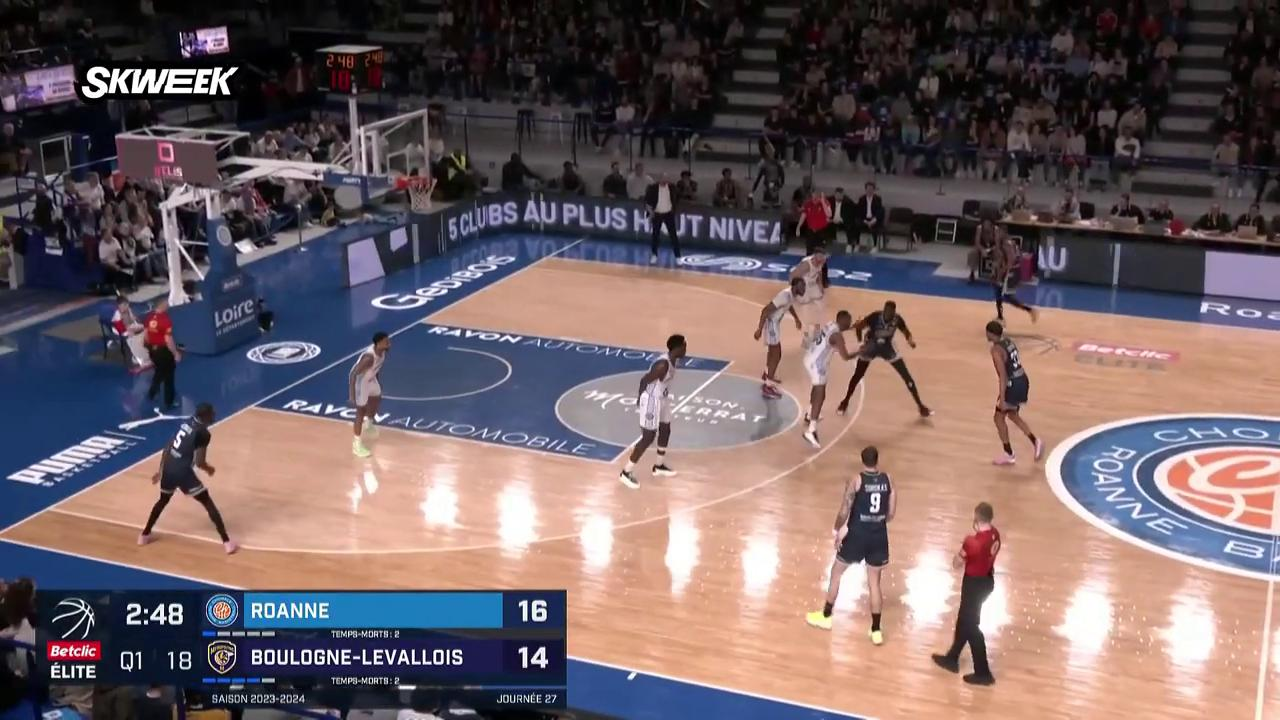

In [3]:
frame_path = "datasets/court_keyPoints/images/test/1.jpg"
frame = Image.open(frame_path)
display(frame)

In [4]:
from ultralytics import YOLO

if __name__ == "__main__":
    model = YOLO("model/court_segmentation.pt")
    results = model.predict(frame_path)


image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\1.jpg: 384x640 1 Center-circle, 1 Paint, 1 basketball-court, 1 three point line, 101.7ms
Speed: 2.0ms preprocess, 101.7ms inference, 103.7ms postprocess per image at shape (1, 3, 384, 640)


In [5]:
results[0].names

{0: 'Center-circle', 1: 'Paint', 2: 'basketball-court', 3: 'three point line'}

In [6]:
# Get the first (and only) result
result = results[0]  

# Extract segmentation masks (result.masks.xy contains polygons, result.masks.data contains binary masks)
if result.masks:
    masks = result.masks.data.cpu().numpy()  # Convert to NumPy array
    class_ids = result.boxes.cls.cpu().numpy()  # Get class IDs for each mask

    # Define your "basketball court" class index (adjust if necessary)
    court_class_idx = 2

    # Find masks corresponding to the basketball court
    court_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for i, cls in enumerate(class_ids):
        if int(cls) == court_class_idx:
            court_mask = np.maximum(court_mask, masks[i])  # Merge court masks if multiple

    # Convert to 255 scale for saving/viewing
    court_mask = (court_mask * 255).astype(np.uint8)

    # Save the binary mask
    cv2.imwrite("basketball_court_mask.png", court_mask)
    print("Binary mask saved as basketball_court_mask.png")

else:
    print("No segmentation masks found in the image.")

Binary mask saved as basketball_court_mask.png


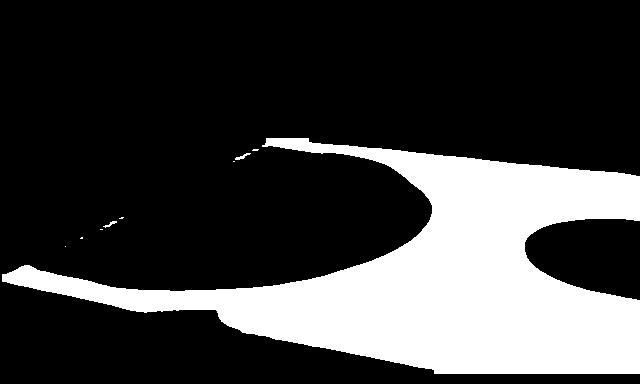

In [7]:
court_mask = Image.open("basketball_court_mask.png")
display(court_mask)

In [8]:
from utils.find_reference_points import find_points

src_leftpts = mapper.extract_points_from_mask(frame_path)



image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\1.jpg: 384x640 1 Center-circle, 1 Paint, 1 basketball-court, 1 three point line, 16.1ms
Speed: 1.6ms preprocess, 16.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


In [9]:
dst_leftpts = np.array([
    list(mapper.court_2d_keypoints[5]), #BL
    list(mapper.court_2d_keypoints[9]), #BR
    list(mapper.court_2d_keypoints[8]), #TR
    list(mapper.court_2d_keypoints[0]), #TL
]) 
dst_leftpts = np.array([
    dst_leftpts[2], #TR
    dst_leftpts[1], #BR
    dst_leftpts[0], #BL
    dst_leftpts[3]  #TL
])

In [10]:
src_leftpts

array([[       1248,      324.38],
       [       1278,      699.38],
       [          4,      513.75],
       [        532,      258.75]], dtype=float32)

In [11]:
dst_leftpts

array([[320,  22],
       [320, 350],
       [ 28, 350],
       [ 28,  22]])

In [12]:
H = mapper.compute_homography(frame_path, "left")


image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\1.jpg: 384x640 1 Center-circle, 1 Paint, 1 basketball-court, 1 three point line, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


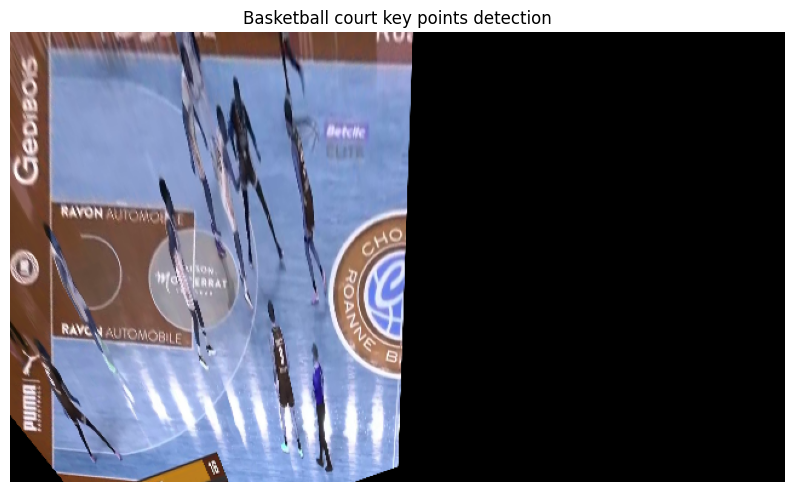

In [13]:
img_dst = cv2.imread('court_diagram.jpeg')
frame = cv2.imread(frame_path)
img_out = cv2.warpPerspective(frame, H, (img_dst.shape[1], img_dst.shape[0]))
plt.figure(figsize=(10, 8))
plt.imshow(img_out)
plt.axis('off')
plt.title('Basketball court key points detection')
plt.show()


image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\1.jpg: 384x640 1 Center-circle, 1 Paint, 1 basketball-court, 1 three point line, 16.6ms
Speed: 1.7ms preprocess, 16.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\1.jpg: 384x640 10 Players, 2 referees, 1 rim, 53.4ms
Speed: 1.4ms preprocess, 53.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
[(166, 274, 0, 1), (83, 357, 0, 0), (212, 194, 0, 0), (254, 226, 0, 0), (236, 355, 0, 0), (202, 228, 0, 1), (175, 177, 0, 1), (87, 279, 0, 1), (-63, -54, 3, -1), (84, 11, 2, -1), (171, 118, 0, 1), (236, 67, 0, 0), (262, 364, 2, -1)]


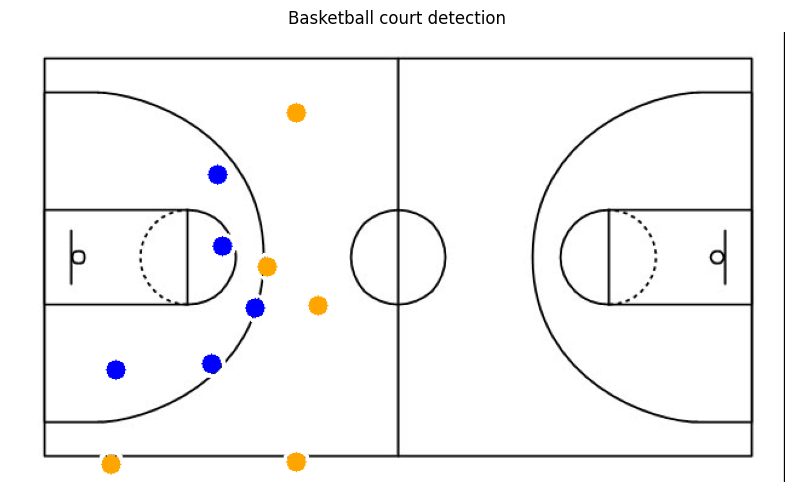

In [14]:
court_image = cv2.imread("court_diagram.jpeg")
court_image = cv2.cvtColor(court_image, cv2.COLOR_BGR2RGB)

player_positions_transformed = mapper.detect_and_map_players(frame_path, "left")
print(player_positions_transformed)

for point in player_positions_transformed:
    x, y, det_label, team = point
    
    if det_label == 0:  # Players
        if team == 0:
            color = (255, 165, 0)  # Orange for team 1
            size = 8
        else:
            color = (0, 0, 255)    # Blue for team 2
            size = 8
    else:  # Ball or other objects
        color = (255, 255, 255)  # White for ball
        size = 4
        
    # Draw marker
    cv2.circle(court_image, (int(x), int(y)), size, color, -1)
    # Add white outline
    cv2.circle(court_image, (int(x), int(y)), size+2, (255, 255, 255), 2)

plt.figure(figsize=(10, 8))
plt.imshow(court_image)
plt.axis('off')
plt.title('Basketball court detection')
plt.show()

In [ ]:
mapper.player_model.predict(frame_path, conf=0.4)[0].boxes.cls


image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\1.jpg: 384x640 10 Players, 2 referees, 1 rim, 23.2ms
Speed: 1.3ms preprocess, 23.2ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 0., 0., 2.], device='cuda:0')

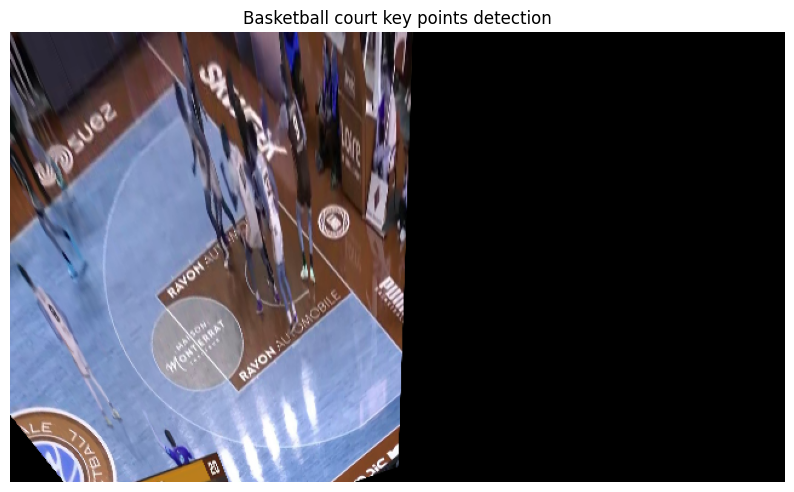


image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\5_right.jpg: 384x640 1 Center-circle, 1 Paint, 1 basketball-court, 1 three point line, 17.4ms
Speed: 1.6ms preprocess, 17.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\5_right.jpg: 384x640 7 Players, 1 rim, 16.0ms
Speed: 1.3ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
[(396, 230, 0, 0), (564, 254, 0, 0), (558, 168, 0, 1), (560, 220, 0, 0), (450, 86, 0, 1), (691, -55, 3, -1), (596, 224, 0, 1), (479, 16, 0, 1)]


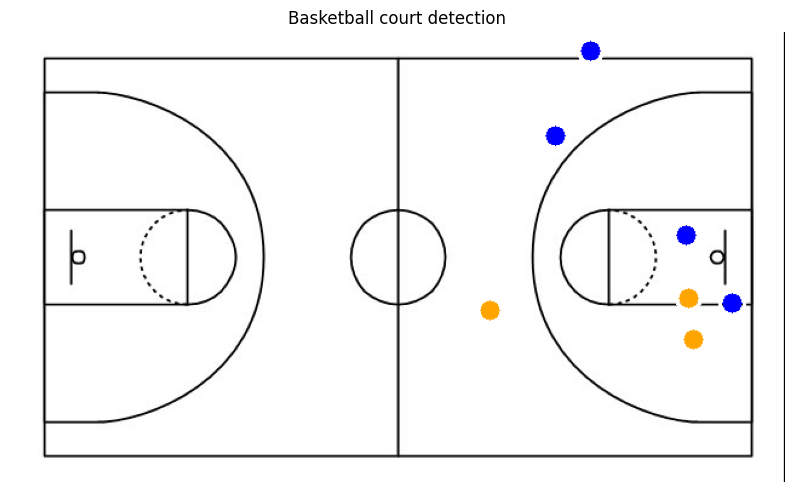

In [ ]:
court_image = cv2.imread("court_diagram.jpeg")
court_image = cv2.cvtColor(court_image, cv2.COLOR_BGR2RGB)
frame_path = "datasets/court_keyPoints/images/test/5_right.jpg"

img_dst = cv2.imread('court_diagram.jpeg')
frame = cv2.imread(frame_path)
img_out = cv2.warpPerspective(frame, H, (img_dst.shape[1], img_dst.shape[0]))
plt.figure(figsize=(10, 8))
plt.imshow(img_out)
plt.axis('off')
plt.title('Basketball court key points detection')
plt.show()

player_positions_transformed= mapper.detect_and_map_players(frame_path, "right")
print(player_positions_transformed)
for point in player_positions_transformed:
    x, y, det_label, team = point
    
    if det_label == 0:  # Players
        if team == 0:
            color = (255, 165, 0)  # Orange for team 1
            size = 8
        else:
            color = (0, 0, 255)    # Blue for team 2
            size = 8
    else:  # Ball or other objects
        color = (255, 255, 255)  # White for ball
        size = 4
        
    # Draw marker
    cv2.circle(court_image, (int(x), int(y)), size, color, -1)
    # Add white outline
    cv2.circle(court_image, (int(x), int(y)), size+2, (255, 255, 255), 2)

plt.figure(figsize=(10, 8))
plt.imshow(court_image)
plt.axis('off')
plt.title('Basketball court detection')
plt.show()

In [ ]:
mapper.extract_points_from_mask(frame_path, visualize=True)



image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\5_right.jpg: 384x640 1 Center-circle, 1 Paint, 1 basketball-court, 1 three point line, 20.6ms
Speed: 1.7ms preprocess, 20.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


array([[        800,      296.25],
       [       1278,      586.88],
       [          0,      699.38],
       [          0,      356.25]], dtype=float32)


image 1/1 C:\Users\maksp\AppData\Local\Temp\tmp49xcesy7.jpg: 384x640 1 Paint, 1 basketball-court, 1 three point line, 89.7ms
Speed: 1.1ms preprocess, 89.7ms inference, 88.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\maksp\AppData\Local\Temp\tmp49xcesy7.jpg: 384x640 9 Players, 3 referees, 1 rim, 46.0ms
Speed: 0.8ms preprocess, 46.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


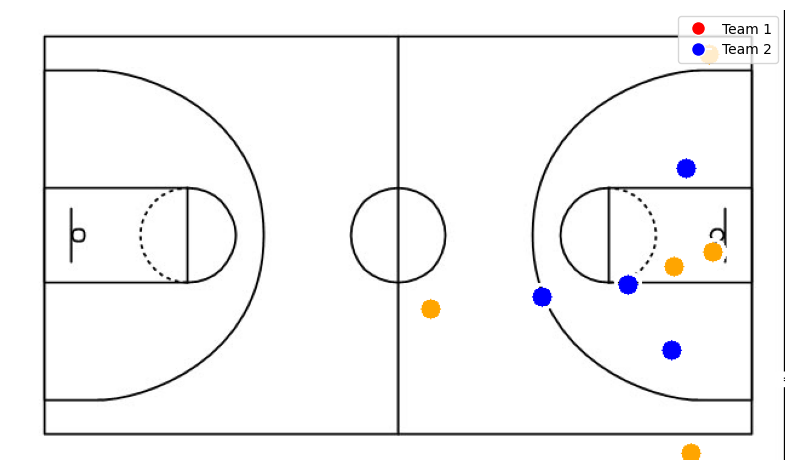


image 1/1 C:\Users\maksp\AppData\Local\Temp\tmpaa3sh8ly.jpg: 384x640 1 Paint, 1 basketball-court, 1 three point line, 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\maksp\AppData\Local\Temp\tmpaa3sh8ly.jpg: 384x640 9 Players, 3 referees, 1 rim, 17.9ms
Speed: 0.9ms preprocess, 17.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\maksp\AppData\Local\Temp\tmp5tnquso5.jpg: 384x640 1 Paint, 1 basketball-court, 1 three point line, 14.3ms
Speed: 0.8ms preprocess, 14.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\maksp\AppData\Local\Temp\tmp5tnquso5.jpg: 384x640 10 Players, 3 referees, 1 rim, 30.9ms
Speed: 1.0ms preprocess, 30.9ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\maksp\AppData\Local\Temp\tmpjlvs0iso.jpg: 384x640 1 Paint, 1 basketball-court, 1 three point line, 14.1ms
Speed: 0.9ms prepro

In [1]:
from utils.video_processor import CourtVideoProcessor

# Process video with smoothing and reduced frame rate
processor = CourtVideoProcessor(
    "test_video/0.0-17.0.mp4", 
    court_part="right",
    buffer_size=15,  # Number of frames for smoothing
    process_nth_frame=2  # Process every 2nd frame
)
processor.process_video(output_path="mapped_output.mp4")


image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\5_right.jpg: 384x640 7 Players, 1 rim, 95.4ms
Speed: 3.3ms preprocess, 95.4ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)


C:\Users\maksp\AppData\Local\Temp\ipykernel_28076\237318530.py:72: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


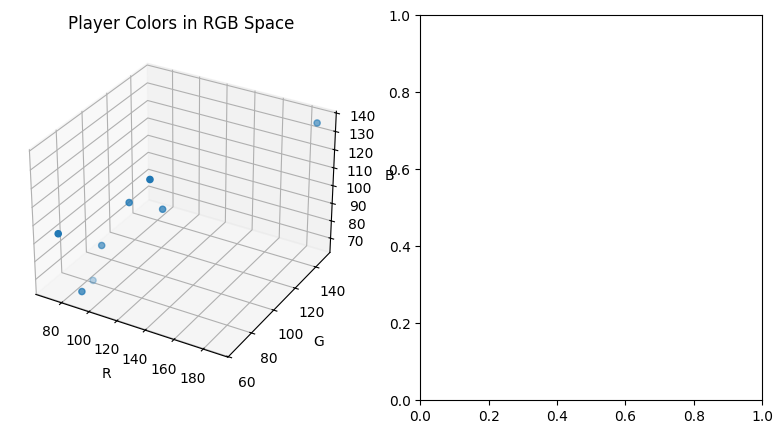

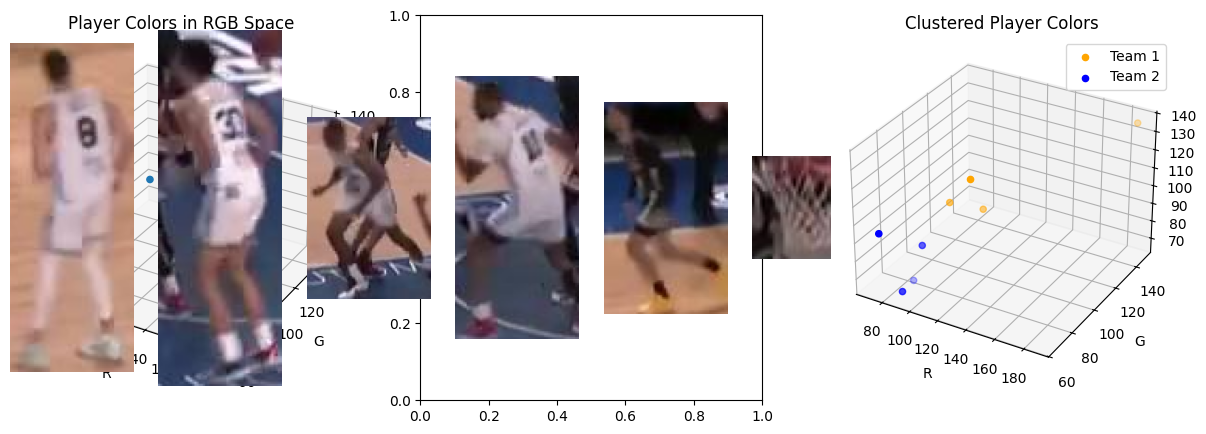

(array([[     188.03,      148.17,      135.91],
        [     110.09,      99.162,      114.46],
        [     119.77,      98.209,      100.78],
        [     101.29,      91.909,      103.83],
        [     91.187,      72.816,      69.047],
        [      89.55,      65.634,      66.735],
        [     69.651,        69.7,       91.96],
        [     92.264,      79.188,      85.183]]),
 array([0, 0, 0, 0, 1, 1, 1, 1], dtype=int32))

In [28]:
result = mapper.player_model.predict(frame_path, conf=0.4)

boxes = result[0].boxes

extract_player_colors(frame_path, boxes, visualize=True)


image 1/1 c:\Users\maksp\Desktop\projects\court_key_points_detection\datasets\court_keyPoints\images\test\5_right.jpg: 384x640 7 Players, 1 rim, 95.9ms
Speed: 3.5ms preprocess, 95.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


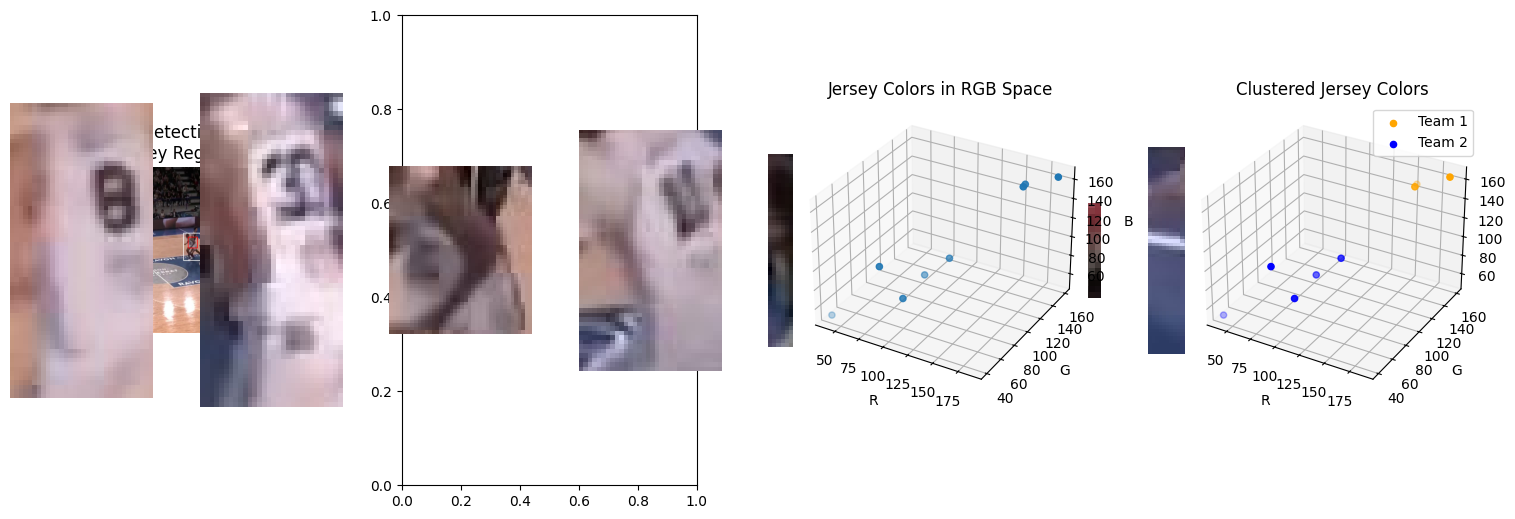

In [29]:
def extract_player_colors(frame, boxes, visualize=False):
    """Extract mean RGB values from center region of player bounding boxes"""
    team_kmeans = KMeans(n_clusters=2, random_state=42)
    team_colors = {
        0: (255, 165, 0),  # Orange for team 1
        1: (0, 0, 255)     # Blue for team 2
    }
    
    frame_rgb = cv2.imread(frame)
    frame_rgb = cv2.cvtColor(frame_rgb, cv2.COLOR_BGR2RGB)
    colors = []
    patches = []  # Store player patches for visualization
    
    for box in boxes:
        xyxy = box.xyxy.cpu().numpy()[0]
        x1, y1, x2, y2 = map(int, xyxy)
        
        # Calculate center region (upper body area where jersey is)
        box_height = y2 - y1
        box_width = x2 - x1
        
        # Define jersey region (approximately upper 40% of the body)
        jersey_top = y1 + int(0.15 * box_height)  # Start below head
        jersey_bottom = y1 + int(0.55 * box_height)  # End above waist
        jersey_left = x1 + int(0.25 * box_width)  # Avoid arms
        jersey_right = x2 - int(0.25 * box_width)
        
        # Extract jersey region
        jersey_roi = frame_rgb[jersey_top:jersey_bottom, jersey_left:jersey_right]
        patches.append(jersey_roi)
        
        # Calculate mean RGB values of jersey region
        mean_color = np.mean(jersey_roi, axis=(0,1))
        colors.append(mean_color)
        
    colors = np.array(colors)
    
    if visualize and len(colors) > 0:
        # Create figure with GridSpec
        fig = plt.figure(figsize=(15, 5))
        gs = gridspec.GridSpec(1, 4)  # Added one more subplot for jersey regions
        
        # 1. Original detections with jersey regions highlighted
        ax0 = fig.add_subplot(gs[0])
        frame_with_regions = frame_rgb.copy()
        for box in boxes:
            xyxy = box.xyxy.cpu().numpy()[0]
            x1, y1, x2, y2 = map(int, xyxy)
            box_height = y2 - y1
            box_width = x2 - x1
            
            # Draw full box in white
            cv2.rectangle(frame_with_regions, (x1, y1), (x2, y2), (255, 255, 255), 2)
            
            # Draw jersey region in red
            jersey_top = y1 + int(0.15 * box_height)
            jersey_bottom = y1 + int(0.55 * box_height)
            jersey_left = x1 + int(0.25 * box_width)
            jersey_right = x2 - int(0.25 * box_width)
            cv2.rectangle(frame_with_regions, 
                        (jersey_left, jersey_top), 
                        (jersey_right, jersey_bottom), 
                        (255, 0, 0), 2)
            
        ax0.imshow(frame_with_regions)
        ax0.axis('off')
        ax0.set_title('Player Detections\nwith Jersey Regions')
        
        # 2. Jersey patches
        ax1 = fig.add_subplot(gs[1])
        n_patches = len(patches)
        for i, patch in enumerate(patches):
            ax_patch = plt.subplot(1, n_patches, i+1)
            ax_patch.imshow(patch)
            ax_patch.axis('off')
        plt.title('Jersey Patches')
        
        # 3. RGB scatter plot
        ax2 = fig.add_subplot(gs[2], projection='3d')
        ax2.scatter(colors[:, 0], colors[:, 1], colors[:, 2])
        ax2.set_xlabel('R')
        ax2.set_ylabel('G')
        ax2.set_zlabel('B')
        ax2.set_title('Jersey Colors in RGB Space')
        
        # 4. Clustered colors
        if len(colors) > 1:
            labels = team_kmeans.fit_predict(colors)
            ax3 = fig.add_subplot(gs[3], projection='3d')
            for team_id in [0, 1]:
                team_colors_cluster = colors[labels == team_id]
                if len(team_colors_cluster) > 0:
                    color = np.array(team_colors[team_id])/255
                    ax3.scatter(team_colors_cluster[:, 0], 
                              team_colors_cluster[:, 1], 
                              team_colors_cluster[:, 2],
                              c=[color], 
                              label=f'Team {team_id+1}')
            ax3.set_xlabel('R')
            ax3.set_ylabel('G')
            ax3.set_zlabel('B')
            ax3.legend()
            ax3.set_title('Clustered Jersey Colors')
        
        plt.tight_layout()
        plt.show()
        
    return colors, team_kmeans.labels_ if len(colors) > 1 else None

result = mapper.player_model.predict(frame_path, conf=0.4)
boxes = result[0].boxes
colors, labels = extract_player_colors(frame_path, boxes, visualize=True)
